In [1425]:
import pandas as pd
import numpy as np

## Algoritmo

In [1426]:
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import pairwise_distances

class KNN:
    
    def __init__(self, E_patrones, E_clases, dist_type="euclidian", k=1, p=1):
        # Guardar patrones y clases como arrays numpy para eficiencia
        self.E_patrones = E_patrones.to_numpy(dtype=np.float64)  # Convirtiendo a numpy array
        self.E_clases = E_clases.to_numpy()  # Convirtiendo a numpy array
        self.K = k
        self.dist_type = dist_type
        self.p = p

    def distancia(self, p1, p2):
        if self.dist_type == "mahalanobis":
            z = np.vstack((p1, p2))
            c = np.cov(z.T)
            return cdist(p1, np.array([p2]), c, metric="mahalanobis").flatten()            
        
        return cdist(p1, np.array([p2]), metric=self.dist_type).flatten()

    def predict(self, p):
        """ Predice la clase del patrón p utilizando el algoritmo KNN. """
        # Convertir el patrón p a un array numpy
        p_array = p.iloc[:-1].to_numpy(dtype=np.float64)  # Excluimos la última columna (etiqueta)

        # Calcular las distancias de p a todos los puntos de E_patrones
        # distancias = np.linalg.norm(self.E_patrones - p_array, axis=1)
        distancias = self.distancia(self.E_patrones, p_array)

        # Obtener los índices de los K vecinos más cercanos
        indices_vecinos = np.argsort(distancias)[:self.K]

        # Obtener las clases de los K vecinos más cercanos
        clases_vecinos = self.E_clases[indices_vecinos]

        # Contar las clases más frecuentes usando np.bincount
        # conteo_clases_ant = np.bincount(clases_vecinos)
        a, conteo_clases = np.unique(clases_vecinos, return_counts=True)
        # print(a)
        # print(conteo_clases, conteo_clases_ant)

        # Obtener la clase con la mayor frecuencia
        clase_predict = a[np.argmax(conteo_clases)]
        # print(a, conteo_clases, clase_predict)

        # Retornar la clase real y la clase predicha
        return [p.iloc[-1], clase_predict]

In [1427]:
def get_matrix_values(positive_class, predictions):
    TP = FN = FP = TN = 0
    for pred in predictions:
        if pred[0] == positive_class:
            if pred[0] == pred[1]:
                TP += 1
            else:
                FN += 1
        else:
            if pred[0] == pred[1]:
                TN += 1
            else:
                FP += 1
    return TP, FN, FP, TN

In [1428]:
import math

def print_results(K, TP, FN, FP, TN):
    accuracy = (TP + TN) / (TP + FN + FP + TN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    precision = "Not Defined"
    if TP + FP != 0:
        precision = TP / (TP + FP)
        
    balanced_accuracy = (sensitivity + specificity) / 2
    
    F1 = "Not defined"
    if precision != 0 and sensitivity != 0:
        F1 = 2*precision*sensitivity/(precision + sensitivity)

    MCC = "Not defined"
    if math.sqrt((TP + FP)*(TP+FN)*(TN+FP)*(TN+FN)) > 0:
        MCC = (TP*TN - FP*FN) / math.sqrt((TP + FP)*(TP+FN)*(TN+FP)*(TN+FN))

    #print(K, "\t", accuracy, "\t", sensitivity, "\t", specificity, "\t", precision, "\t", balanced_accuracy, "\t", F1, "\t", MCC)
    return str(K) + "\t" + str(accuracy) + "\t" + str(balanced_accuracy) + "\t" + str(sensitivity) + "\t" + str(specificity) + "\t" + str(precision) + "\t" + str(F1) + "\t" + str(MCC) + "\n"

In [1429]:
def get_BA(TP, FN, FP, TN):
    accuracy = (TP + TN) / (TP + FN + FP + TN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
        
    balanced_accuracy = (sensitivity + specificity) / 2

    return balanced_accuracy

In [1430]:
def LOO(df, K, distance_metric):
    predictions = []
    for p_index, p in df.iterrows():
        df_loo = df[df.index != p_index]
        E_patrones = df_loo.iloc[:, :-1]
        E_clases = df_loo.iloc[:, -1]
        knn = KNN(E_patrones, E_clases, distance_metric, K)
        pred = knn.predict(p)
        predictions.append(pred)
    return predictions
        

In [1431]:
import os

def exec_KNN(metrics, k_values, dataset_name, clase_positive):
    df = pd.read_csv("datasets/" + dataset_name + ".csv", header=None)
    for distance_metric in metrics:
        for K in k_values:
            data = "K\tAccuracy\tBalanced Accuracy\tSensitivity\tSpecificity\tPrecision\tF1-Score\tMCC\n"
            pred = LOO(df, K, distance_metric)
            TP, FN, FP, TN = get_matrix_values(clase_positive, pred)
            data += print_results(K, TP, FN, FP, TN)
            # print(TP, FN, FP, TN)

            if not os.path.exists(dataset_name):
                os.makedirs(dataset_name)

            final_dir = dataset_name+"/"+distance_metric+"/"
            if not os.path.exists(final_dir):
                os.makedirs(final_dir)
                
            with open(final_dir + dataset_name + "_" + str(K) + '_NN' + "_" + str(distance_metric) + ".tsv", 'w') as f:
                f.write(data)

In [1432]:
import os
import math

def exec_KNN(metrics, k_values, dataset_name, clase_positive):
    df = pd.read_csv("datasets/" + dataset_name + ".csv", header=None)

    data = "K\t"
    data += "\t".join(metrics)+"\n"

    df_plot = pd.DataFrame()
    df_plot['values'] = [] #Values
    df_plot['labels'] = [] #Labels (manhattan, K=1)
    labels = []
    values = []
    
    for K in k_values:
        data += str(K)
        for distance_metric in metrics:
            pred = LOO(df, K, distance_metric)
            TP, FN, FP, TN = get_matrix_values(clase_positive, pred)
            BA = get_BA(TP, FN, FP, TN)
            labels.append(distance_metric + " , K=" + str(K))
            values.append(float(BA))
            
            BA = f'{BA:.4f}'
            data += "\t" + BA
            
        data += "\n"

    if not os.path.exists(dataset_name):
        os.makedirs(dataset_name)

    with open(dataset_name + "/" + dataset_name + ".tsv", 'w') as f:
        f.write(data)

    df_plot['labels'] = labels
    df_plot['values'] = values 
    df_plot['values'] = np.trunc(df_plot['values'] * 10000) / 100
    plotRanking(df_plot, dataset_name)
    plt.savefig(dataset_name + "/" + dataset_name+".png", bbox_inches='tight')

In [1433]:
from matplotlib import pyplot as plt
def plotRanking(df, title):
    # Figure Size
    fig, ax = plt.subplots(figsize =(8, 5))
    df = df.sort_values(["values", "labels"], ascending=[True, False])
    # df = df.sort_values("values")
    # Horizontal Bar Plot

    ax.set_xlim(0, 100)
    bars = ax.barh(df["labels"], df["values"])
    ax.bar_label(bars, labels=[f'{value}%' for value in df["values"]])
    plt.title(title)
    # ax.bar_label(bars)
    # axes = plt.axes()
    # axes.set_ylim([0, 1])
    
    # Remove axes splines
    # for s in ['top', 'bottom', 'left', 'right']:
    #     ax.spines[s].set_visible(False)
    

In [1434]:
metrics = ["euclidean", "cityblock", "chebychev"]

In [1435]:
k_values = [1,3,5]

## Nutt

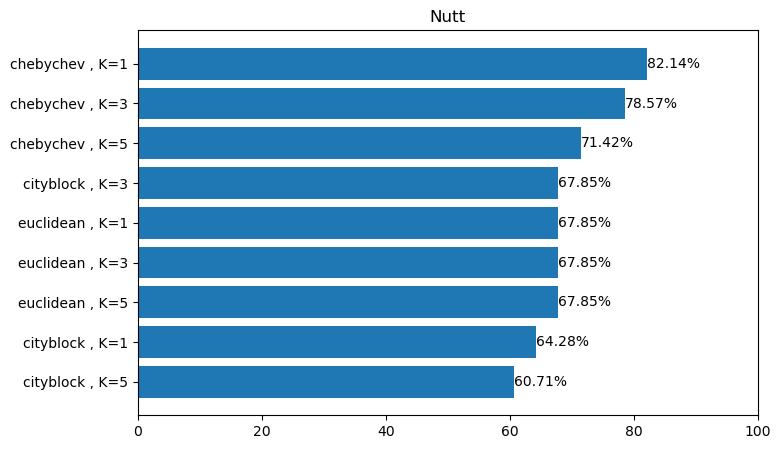

In [1420]:
exec_KNN(metrics, k_values, "Nutt", clase_positive=0)

## Sonar

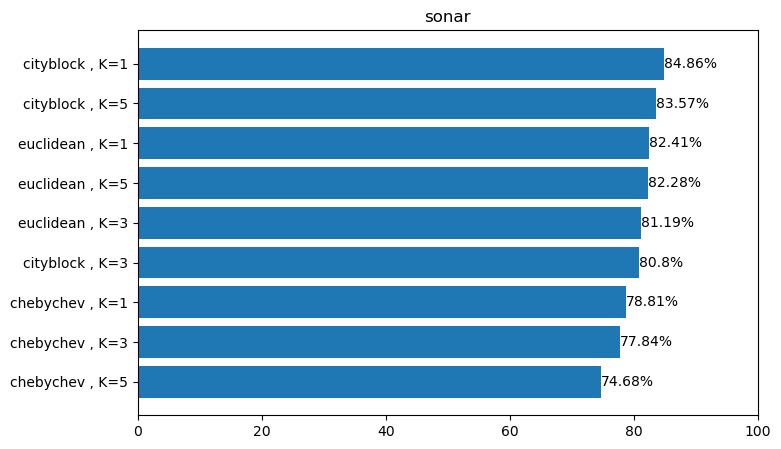

In [1401]:
exec_KNN(metrics, k_values, "sonar", clase_positive=" M")

## Haberman

In [1439]:
metrics = ["chebychev", "cityblock", "euclidean"]

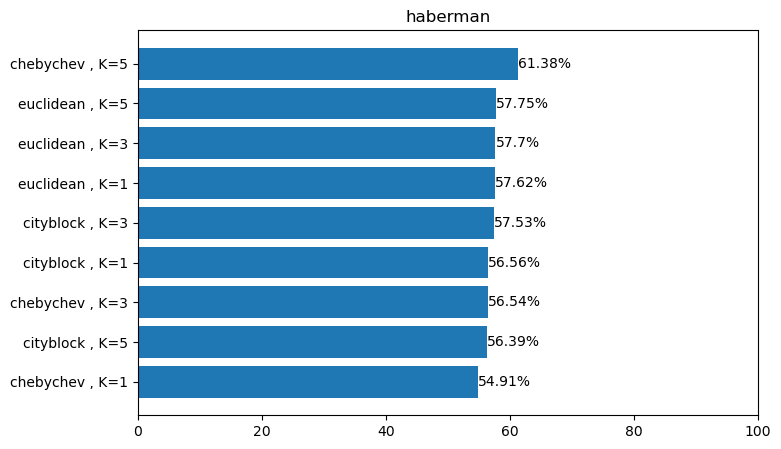

In [1440]:
exec_KNN(metrics, k_values, "haberman", clase_positive=" positive")

## Electricity

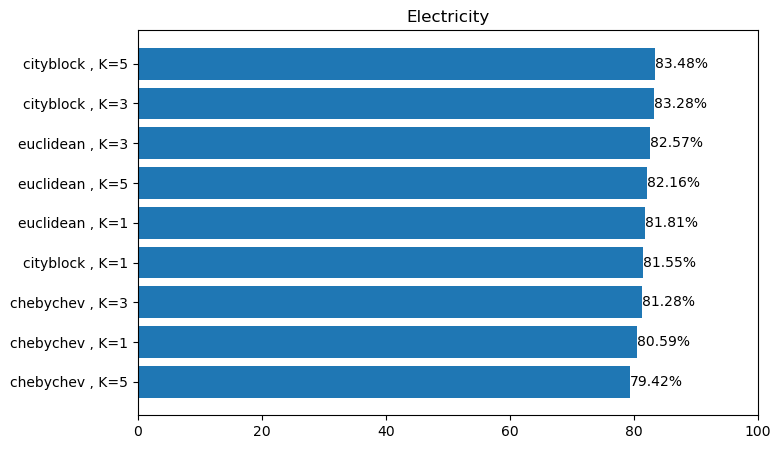

In [1406]:
exec_KNN(metrics, k_values, "Electricity", clase_positive=1)

## Heart

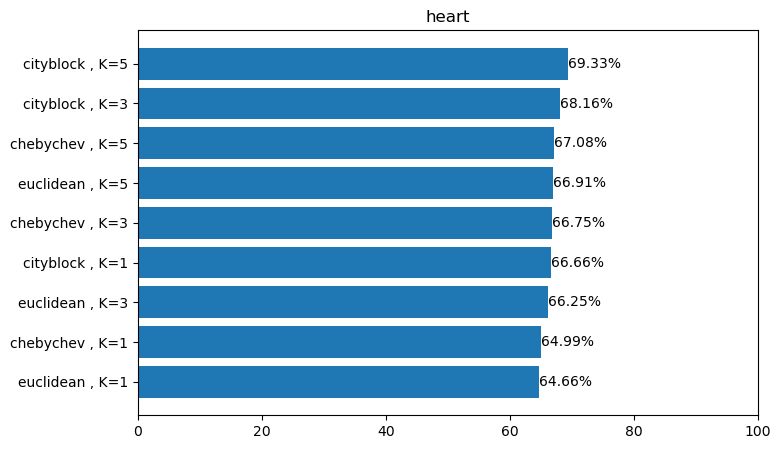

In [1402]:
exec_KNN(metrics, k_values, "heart", clase_positive=2) # Documentation

## Spam

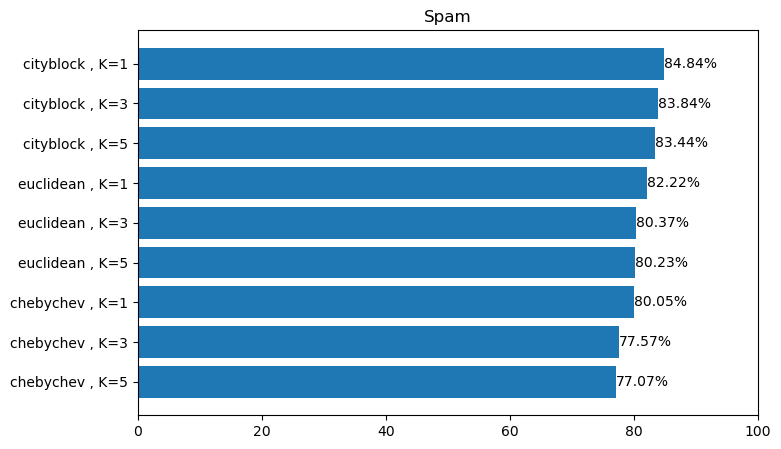

In [1407]:
exec_KNN(metrics, k_values, "Spam", clase_positive=1)

## Monk-2

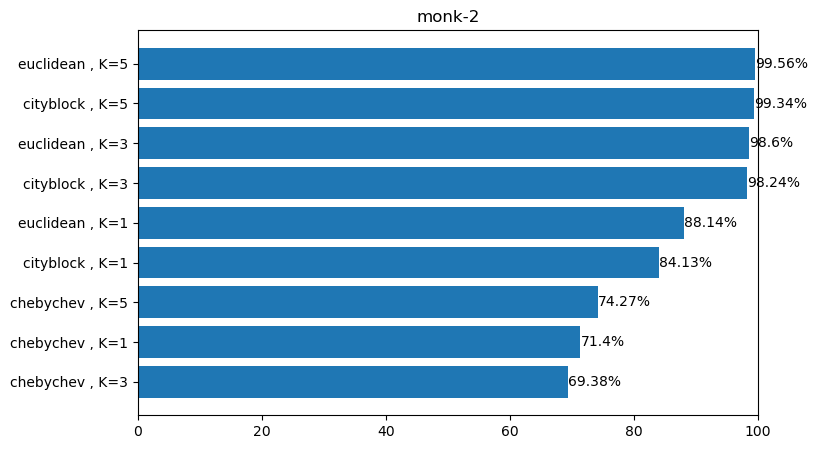

In [1404]:
exec_KNN(metrics, k_values, "monk-2", clase_positive=0)

## Ionosphere

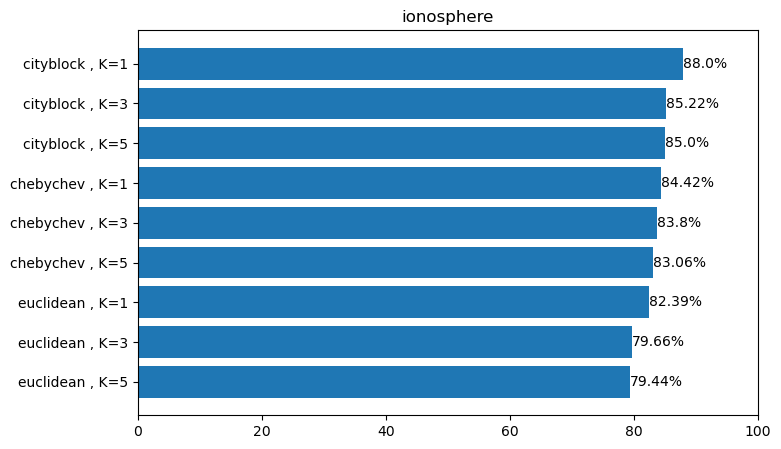

In [1403]:
exec_KNN(metrics, k_values, "ionosphere", clase_positive=" b")

## WDBC

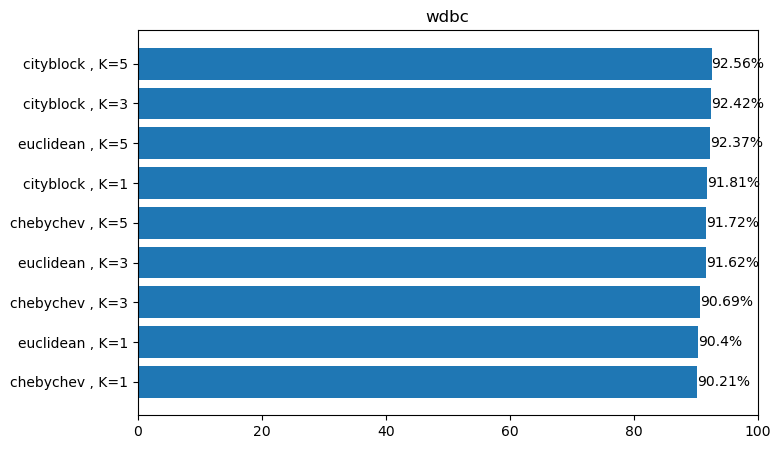

In [1405]:
exec_KNN(metrics, k_values, "wdbc", clase_positive="M")

## Apendicitis

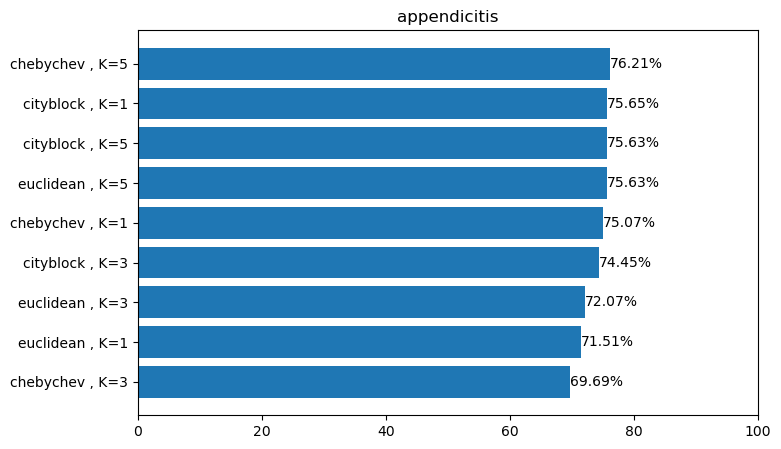

In [1436]:
exec_KNN(metrics, k_values, "appendicitis", clase_positive=1)

In [793]:
from scipy.spatial import distance
class KNN:
    
    def __init__(self, E, dist_type="euclidian", k=1):
        self.E_patrones = E.iloc[:, :-1]
        self.E_clases = E.iloc[:, -1]
        self.K = k
        self.dist_type = dist_type

    def distancia(self, p1, p2):
        match self.dist_type:
            case "euclidian":
                # print("euclidian")
                return distance.euclidean(p1,p2)
                return np.sqrt(sum((p1 - p2)**2))
            case "chessboard":
                # print("chessboard")
                return np.max(abs(p1 - p2))
            case "city_block":
                # print("city_block")
                return np.sum(abs(p1 - p2))
    
    def predict(self, p):
        clase = None
        pattern = None
        min_dist = float('inf')
        for e_index, e in self.E_patrones.iterrows():
            dist = self.distancia(p[:-1], e)
            if dist < min_dist:
                min_dist = dist
                pattern = e_index + 1
                clase = self.E_clases[e_index]
                    
        return [int(p.iloc[-1]), clase]

In [794]:
def LOO(df, K):
    predictions = []
    for p_index, p in df.iterrows():
        df_loo = df[df.index != p_index]
        knn = KNN(df_loo,"euclidian")
        pred = knn.predict(p)
        predictions.append(pred)
    return predictions

In [930]:
from tabulate import tabulate

# Print confusion matrix
df = pd.read_csv("datasets/5_Nutt.csv", header=None)
data = "K\tAccuracy\tBalanced Accuracy\tSensitivity\tSpecificity\tPrecision\tF1-Score\tMCC\n"

distance_metric = "euclidian"
K = 1

pred = LOO(df, K, distance_metric)
TP, FN, FP, TN = get_matrix_values(0, pred)
data += print_results(K, TP, FN, FP, TN)

with open('NUTTTTTT' + str(K) + "_" + str(distance_metric) + ".tsv", 'w') as f:
    f.write(data)